# Neural Fields for 3D Reconstruction

This notebook steps through the use of neural network representations for 3D reconstruction: namely, given a set of 2D camera images, we want to infer the structure of the 3D scene/object that produced the images. This problem is known as inverse rendering.


To start, we need to generate some training data. We will be using a rendering tool developed at SLAC: [gradoptics](https://github.com/Magis-slac/gradoptics). 

Begin by installing all of the dependencies. 

**If running in Colab, change your runtime to GPU (Runtime>Change Runtime Type>Hardware Accelerator>GPU)**

## Basic dependencies:

gradoptics is a ray-tracing simulator written in PyTorch. It uses the straight-line nature of light, as well as known interactions with optical elements, to render a scene.

In [1]:
import gradoptics as optics
from gradoptics.optics.ray import Rays
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from glob import glob

from utils import cos_theta, get_sensors, kwindows, weighted_sampler, backward_ray_tracing
from point_cloud_distribution import PointCloudDistribution

import torch
from scipy.spatial.transform import Rotation as R
import pickle
from pathlib import Path


## Helper functions

We start out with a few helper functions to set up a system of cameras. In all of the following we assume that the object we're interested in imaging is at the origin $(0, 0, 0)$. 

`gradoptics` has a default camera orientation (along the $+x$ axis). We would like to place arbitrary cameras in 3D space and orient them to point at the object of interest (at the origin). The first function, `point_to_origin`, gives the appropriate Euler angle rotation to do this.

In [2]:
def point_to_origin(cam_position):
    # Default is point along positive x
    current_dir = torch.tensor([1., 0., 0.]).type(cam_position.dtype)
    
    # Vector pointing towards the origin
    new_dir = -cam_position/torch.norm(cam_position)
    
    # Get a perpendicular axis, handling axis aligned cases
    if torch.allclose(torch.abs(new_dir), torch.abs(current_dir)):
        axis = torch.tensor([0., 0., 1.]).double()
    else:
        axis = torch.cross(current_dir, new_dir)
     
    # Normalize
    axis *= 1/torch.norm(axis)
    
    # Get rotation angle via dot product
    angle = torch.acos(torch.dot(current_dir,new_dir)/(torch.norm(current_dir)*torch.norm(new_dir)))
    
    # Get Euler angles from rotation vector using scipy (right handed coordinate system)
    theta_x, theta_y, theta_z = R.from_rotvec(axis*angle).as_euler('xyz')
    
    # Gradoptics rotations need left handed coordinate system -- flip sign on y
    return theta_x, -theta_y, theta_z

We'll be operating at a fixed magnification, but adjusting camera positions and focal lengths. We can use the lensmakers formula to keep everything consistent/in focus

In [3]:
def calculate_focal_length(m, obj_distance):
    f =  np.array(obj_distance) / (1 / np.array(m) + 1)
    return f.astype(np.float32)

`gradoptics` works in terms of `Scene` objects and optical elements within them. We can add multiple cameras to a scene, where a camera is a `Lens` and a `Sensor`. For this tutorial, we've fixed a magnification of `m=0.1` for all cameras and a sensor size of $200 \times 200$ pixels. 

`setup_scene` places an arbitrary number of cameras pointing at the origin in a scene, given sets of spherical coordinates (`thetas` for polar angles from the $+z$ axis, `phis` for azimuthal angles, and `rs` for radii, in meters).

In [4]:
def setup_scene(scene, thetas=[], phis=[], rs=[], m=[], na=[1/1.4], mode='40k'):
    #Make sure the number of cameras matches between arguments
    assert len(thetas) == len(phis), "thetas and phis should have the same length"
    assert len(rs) == len(thetas), "rs and thetas should have the same length"
    assert len(m) == len(thetas), "m and thetas should have the same"
    
    n_cameras = len(thetas)
    
    # Given distance from object and magnification, calculate focal length for in focus object
    #m = 0.1
    f = calculate_focal_length(m, rs)
    
    # Numerical aperture (size of camera opening, f-number)
    #na = 1/1.4
    if mode=='40k':
        res=(200, 200)
        pixsize = (2.4e-6, 2.4e-6)
    elif mode=='400':
        res=(20, 20)
        pixsize = (2.4e-5, 2.4e-5)
    elif mode=='40klarge':
        res=(200, 200)
        pixsize = (2.4e-5, 2.4e-5)
    elif mode=='400large':
        res=(20, 20)
        pixsize = (4.8e-5, 4.8e-5)
    else:
        print('wrong mode!')
        exit(1)
    
    # Loop over cameras to add to scene
    for i_cam in range(n_cameras):
        # Avoid singular point with slight offset
        if thetas[i_cam] == 0:
            thetas[i_cam] = 1e-6
            
        # Get cartesian coordinates from spherical
        x_cam = rs[i_cam]*np.sin(thetas[i_cam])*np.cos(phis[i_cam])
        y_cam = rs[i_cam]*np.sin(thetas[i_cam])*np.sin(phis[i_cam])
        z_cam = rs[i_cam]*np.cos(thetas[i_cam])
        
        cam_pos = torch.tensor([x_cam, y_cam, z_cam])

        # Get orientation to point at origin and apply to lens
        angles = point_to_origin(cam_pos)
        transform = optics.simple_transform.SimpleTransform(*angles, cam_pos)
        lens = optics.PerfectLens(f=f[i_cam], m=m[i_cam], na=na[i_cam],
                                  position = cam_pos,
                                  transform = transform)

        # Sensor position from lensmakers equation, rotated to match lens
        rel_position = torch.tensor([-f[i_cam] * (1 + m[i_cam]), 0, 0]).float()                       
        rot_position = torch.matmul(transform.transform.float(), torch.cat((rel_position, torch.tensor([0]))))

        sensor_position = cam_pos + rot_position[:-1]
        viewing_direction = torch.matmul(transform.transform.float(), torch.tensor([1.,0,0,0]))

        sensor = optics.Sensor(position=sensor_position, viewing_direction=tuple(viewing_direction.numpy()),
                               resolution=res, pixel_size=pixsize,
                               poisson_noise_mean=2.31, quantum_efficiency=0.72)
        
        # Add sensor and lens to the scene
        scene.add_object(sensor)
        scene.add_object(lens)
        
    return scene, n_cameras

## Example scene/training data

One useful physics context for a 3D reconstruction is the imaging of clouds of atoms. This will be the data that we generate/use for this tutorial.

We here set up a scene with a 1mm Gaussian atom cloud at the origin, and three cameras pointing at it: one along the x-axis, one along the y-axis, and one along the z-axis. For later use, we define a spherical region of interest around the origin with radius 5mm, which will cover all the light that would be captured on our given sensor/be sufficiently large for our atom cloud.

In [5]:
#from gradoptics.optics.bounding_box import BoundingBox

#k_fringe = 1 / (0.00001*2)
k_fringe = 1 / (0.00003*2) # default
#k_fringe = 1 / (0.000005*2) # no fringes from off-axis z view

phiphase=-1.0

cloud0 = optics.AtomCloud(position=[0., 0., 0.], k_fringe=k_fringe, phi=phiphase)


# flat light source
#width=0.02
#thickness = 0.0001
#scene = optics.Scene(optics.LightSourceFromDistribution(FlatSquareDistribution(position=[0., 0., 0.], width=width, thickness=thickness)))

def sample_sphere(radius, nb_points, device='cuda'):
    costheta = -1.0 + 2.0 * torch.rand(nb_points, device=device)
    theta= torch.acos(costheta)
    phi = 2 * np.pi * torch.rand(nb_points, device=device)
    r = radius * torch.pow(torch.rand(nb_points, device=device), 1/3)
    x = r * torch.sin(theta) * torch.cos(phi)
    y = r * torch.sin(theta) * torch.sin(phi)
    z = r * costheta
    del costheta
    del phi
    return optics.batch_vector(x, y, z)

#atoms = sample_sphere(0.0005, 100000).double()
atoms = 0.0005*torch.randn((100000,3), device='cuda')
#atomlist = [[-0.001, 0.0, 0.0], [0.001, 0.001, 0.0]]
#atoms = torch.tensor(atomlist, device='cuda')
cloud0 = PointCloudDistribution(atoms, sigma=5e-6, nbins=7)

c:\extrasoftware\anaconda202309\envs\magisslac\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
lightsource = optics.LightSourceFromDistribution(cloud0)
scene = optics.Scene(lightsource)

# camera position
ncams = 2
mode='40k'
#deltaphi = 0.3 # no bias but fuzzy
#deltaphi = np.pi/4 # no bias but fuzzy
deltaphi = 0.0
#deltaphi = np.pi/3 # no bias clear after 4k steps
#deltaphi = np.pi*75/180 # no bias clear after 4k steps
#deltaphi = np.pi/2-0.1

if ncams==5:
    camthetas= [np.pi/2, np.pi/2, 0., np.pi/16, np.pi/16]
    camphis = [0., np.pi/2., 0., np.pi/2, 3*np.pi/2]
    camrs = [5e-2, 5e-2, 5e-2, 4e-1, 4e-1]
    cammag = [0.1, 0.1, 0.1, 0.1, 0.1]
    camna = [1/1.4, 1/1.4, 1/1.4, 1/8., 1/8.]
elif ncams==4:
    camthetas= [np.pi/2, np.pi/2,  np.pi/16, np.pi/16]
    camphis = [0. + deltaphi, np.pi/2. + deltaphi, np.pi/2 + deltaphi, 3*np.pi/2 + deltaphi] 
    camrs = [5e-2, 5e-2, 4e-1, 4e-1]
    cammag = [0.1, 0.1, 0.1, 0.1]
    #camna = [1/1.4, 1/1.4, 1/8.0, 1/8.0]
    #camna = [1/1.4, 1/1.4, 1/4.0, 1/4.0]
    camna = [1/1.4, 1/1.4, 1/2.0, 1/2.0]
elif ncams==3:
    #camthetas= [np.pi/2, np.pi/2,  0]
    #camphis = [0., np.pi/2., -np.pi/2]
    #camrs = [5e-2, 5e-2, 5e-2]
    #cammag = [0.1, 0.1, 0.1]
    #camna = [1/1.4, 1/1.4, 1/1.4]
    #camthetas= [np.pi/2, np.pi/16, np.pi/16]
    #camphis = [0., np.pi/2, 3*np.pi/2]
    #camrs = [5e-2, 4e-1, 4e-1]
    #cammag = [0.1, 0.1, 0.1]
    #camna = [1/1.4, 1/5.6, 1/5.6]
    dth = 21.0/180.0 * np.pi
    dph = 15.0/180.0 * np.pi
    camthetas= [np.pi/2, np.pi/2, np.pi/2 + dth, ]
    camphis = [0. + deltaphi, np.pi/2 + deltaphi, dph + deltaphi, ] 
    camrs = [1.75e-1, 1.75e-1, 1.75e-1, ]
    cammag = [0.1, 0.1, 0.1, ]
    camna = [1/2.0, 1/2.0, 1/2.0, ]
elif ncams==2:
    camthetas= [np.pi/2, np.pi/2]
    camphis = [0. + deltaphi, np.pi/2. + deltaphi]
    camrs = [5e-2, 5e-2]
    cammag = [0.1, 0.1]
    camna = [1/1.4, 1/1.4]
elif ncams==6:
    dth = 21.0/180.0 * np.pi
    dph = 15.0/180.0 * np.pi
    camthetas= [np.pi/2, np.pi/2, np.pi/2 + dth, np.pi/2 - dth, np.pi/2 + dth, np.pi/2 -dth,]
    camphis = [0. + deltaphi, np.pi/2 + deltaphi, dph + deltaphi, dph + deltaphi, -dph + deltaphi, -dph + deltaphi, ] 
    camrs = [1.75e-1, 1.75e-1, 1.75e-1, 1.75e-1, 1.75e-1, 1.75e-1]
    cammag = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1,]
    camna = [1/2.0, 1/2.0, 1/2.0, 1/2.0, 1/2.0, 1/2.0]


scene, n_cameras = setup_scene(scene, camthetas, camphis, camrs, cammag, camna, mode)

scene.light_source.bounding_shape = optics.BoundingSphere(radii=0.003, xc=0, yc=0, zc=0)

# bounding box for flat light source
#scene.light_source.bounding_shape = BoundingBox(xc=0, yc=0, zc=0, dx=width, dy=width, dz=thickness)

In [7]:
calculate_focal_length(0.4, 0.175)

0.05

Visualizing the scene:

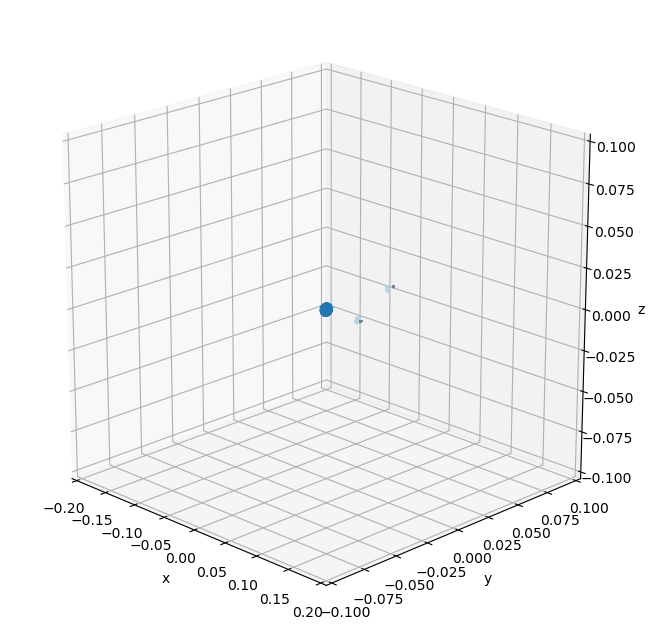

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', box_aspect=(0.5,0.5,0.5))
scene.plot(ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.1, 0.1)
ax.set_zlim(-0.1, 0.1)
ax.view_init(20, -45)
plt.show()

## Rendering and backward ray tracing

Now that we have our scene and our cameras, we want to generate some images! We will do so using _backward ray tracing_.

In _forward ray tracing_, light is emitted in all directions from a given light source, and we keep track of the light that hits our camera sensors. This nicely corresponds to physical intuition, but is inefficient: our cameras don't cover a large area of space, so many light rays need to be generated to get good images.

In _backward ray tracing_, we say that we only care about light that hits pixels on our camera sensors. Since the light rays translate through our system along the same paths moving forward or backward in time, we instead generate rays at each of our camera pixels. By _integrating_ along these light rays through the object of interest, we can calculate the contribution of a light source to each pixel. 


To do this backward ray tracing, we need to generate appropriate rays. A ray is defined by an origin $\mathbf{o}$ and a direction $\mathbf{d}$, with a given point along a ray at time $t$ given by
\begin{equation}
\mathbf{r}(t) = \mathbf{o} + t\cdot \mathbf{d}
\end{equation}

We therefore first need to get coordinates of each pixel (the origins of each of our rays).

In [9]:
def get_pixel_coords(sensor):
    # Pixel coordinates in camera space
    x = torch.linspace(-sensor.pixel_size[0]*sensor.resolution[0]/2 + sensor.pixel_size[0]/2,
                         sensor.pixel_size[0]*sensor.resolution[0]/2 - sensor.pixel_size[0]/2, 
                         sensor.resolution[0])

    y = torch.linspace(-sensor.pixel_size[1]*sensor.resolution[1]/2 + sensor.pixel_size[1]/2,
                         sensor.pixel_size[1]*sensor.resolution[1]/2 - sensor.pixel_size[1]/2, 
                         sensor.resolution[1])
    
    pix_x, pix_y = torch.meshgrid(x, y)
    
    pix_z = torch.zeros((sensor.resolution[0], sensor.resolution[1]))
    
    all_coords = torch.stack([pix_x, pix_y, pix_z], dim=-1).reshape((-1, 3)).double()
    
    # Use transforms from above setup to go from pixel space to real (world) space
    return sensor.c2w.apply_transform_(all_coords)

To complete the rays, we then need a set of directions. For simplicity, we here consider the case of a pinhole camera (all the rays start from pixels and pass through the center of the lens).

In [10]:
def get_rays_pinhole(sensor, lens, nb_rays=None, ind=None, device='cuda', return_ind=False):
    
    if ind is None:
        #Set up for ray batching -- nb_rays switches between all pinhole rays or random batches
        if nb_rays == None or nb_rays == sensor.resolution[0]*sensor.resolution[1]:
            ind = torch.arange(0, sensor.resolution[0]*sensor.resolution[1])
        else:
            ind = torch.randint(0, sensor.resolution[0]*sensor.resolution[1], (nb_rays,))
    
    # Get origins
    all_pix_coords = get_pixel_coords(sensor)  
    origins = all_pix_coords[ind]
    
    #Get directions to center of lens
    lens_center = lens.transform.transform[:-1, -1]
    
    directions = optics.batch_vector(lens_center[None, 0] - origins[:, 0],
                                     lens_center[None, 1] - origins[:, 1],
                                     lens_center[None, 2] - origins[:, 2]).type(origins.dtype)

    # Set up rays
    rays_sensor_to_lens = Rays(origins, directions, device=device)
    
    if return_ind:
        return rays_sensor_to_lens, ind
    else:
        return rays_sensor_to_lens

In [11]:
def sample_on_pixels(sensor, samples_per_pixel, idx, idy, device='cpu'):
    """
    Sample data on the pixels whose id are provided

    :param samples_per_pixel: Number of samples per pixel (:obj:`int`)
    :param idx: Pixel indices along the horizontal axis, assuming a coordinate system centered in the center of
                the image(:obj:`torch.tensor`)
    :param idy: Pixel indices along the vertical axis, assuming a coordinate system centered in the center of
                the image(:obj:`torch.tensor`)
    :param device: The desired device of returned tensor (:obj:`str`). Default is ``'cpu'``

    :return: (:obj:`tuple`) Sampled points (:obj:`torch.tensor`) and p(A) (:obj:`float`)
    """

    assert idx.shape[0] == idy.shape[0]
    nb_pixels = idx.shape[0]

    samples = torch.zeros((nb_pixels, samples_per_pixel, 3), device=device)
    samples[:, :, 0] = (idx.to(device)[..., None] + 0.5) * sensor.pixel_size[0]  + (torch.rand((nb_pixels, samples_per_pixel), device=device)-0.5) * sensor.pixel_size[0]
    samples[:, :, 1] = (idy.to(device)[..., None] + 0.5) * sensor.pixel_size[1]  + (torch.rand((nb_pixels, samples_per_pixel), device=device)-0.5) * sensor.pixel_size[1]

    return (sensor.c2w.apply_transform_(samples.reshape(-1, 3)).reshape((nb_pixels, samples_per_pixel, 3)),
            1 / (sensor.resolution[0] * sensor.pixel_size[0] * sensor.resolution[1] * sensor.pixel_size[1]))

In [12]:
def sample_on_sensor(sensor, nb_rays, device='cpu'):
    """
    Sample data on the pixels whose id are provided

    :param nb_rays: Number of samples (:obj:`int`)

    :param device: The desired device of returned tensor (:obj:`str`). Default is ``'cpu'``

    :return: (:obj:`tuple`) Sampled points (:obj:`torch.tensor`) and p(A) (:obj:`float`)
    """
    # number of pixels
    nxpix = sensor.resolution[0]
    nypix = sensor.resolution[1]
    samples_per_pixel = 1

    randidx = torch.randint(0, nxpix, (nb_rays, ), device=device)
    randidy = torch.randint(0, nxpix, (nb_rays, ), device=device)
    #randind = randidy*sensor.resolution[0] + randidx
    randind = randidx*sensor.resolution[1] + randidy

    ones = torch.ones((nb_rays, ), dtype=torch.float64, device=device)

    samples = torch.zeros((nb_rays, 3), device=device)
    samples[:, 0] = (-nxpix/2*ones + randidx + torch.rand((nb_rays, ), device=device)-0.5 )*sensor.pixel_size[0]
    samples[:, 1] = (-nypix/2*ones + randidy + torch.rand((nb_rays, ), device=device)-0.5 )*sensor.pixel_size[1]
    

    return (sensor.c2w.apply_transform_(samples.reshape(-1, 3)).reshape((nb_rays, samples_per_pixel, 3)),
            1 / (sensor.resolution[0] * sensor.pixel_size[0] * sensor.resolution[1] * sensor.pixel_size[1]),
            randind)

In [13]:
def render_pixels(sensor, lens, scene, light_source, samples_per_pixel, directions_per_sample, px_i, px_j, integrator,
                  device='cpu', max_iterations=3):

    # Sampling on the sensor
    #ray_origins, p_a1 = sensor.sample_on_pixels(samples_per_pixel, px_i, px_j, device=device)
    ray_origins, p_a1 = sample_on_pixels(sensor, samples_per_pixel, px_i, px_j, device=device)
    ray_origins = ray_origins.reshape(-1, 3).double()
    ray_origins = ray_origins.expand([directions_per_sample] + list(ray_origins.shape)
                                     ).transpose(0, 1).reshape(-1, 3)

    # Sampling directions
    p_prime, p_a2 = lens.sample_points_on_lens(ray_origins.shape[0], device=device)

  

    # not normalized
    ray_directions = optics.batch_vector(p_prime[:, 0] - ray_origins[:, 0], p_prime[:, 1] - ray_origins[:, 1],
                                         p_prime[:, 2] - ray_origins[:, 2])
    ray_lenssource = optics.batch_vector(p_prime[:, 0] , p_prime[:, 1] , p_prime[:, 2])

    # @Todo, generalization needed
    sensor_normal = (lens.transform.transform[:-1, -1]-torch.tensor(sensor.position)).to(device)
    sensor_normal *= 1./torch.norm(sensor_normal)

    # distance squared of each ray
    r2 = optics.dot_product(ray_directions, ray_directions)
    #r2 = optics.dot_product(ray_lenssource, ray_lenssource)

    # orig
    cos_theta_ray = cos_theta(sensor_normal[None, ...], ray_directions)
    cos_theta_orig = cos_theta(sensor_normal[None, ...], ray_origins) 
    #cos_theta_ray = cos_theta(sensor_normal[None, ...], -ray_lenssource)

    xsperp = ray_origins - cos_theta_orig[:, None] * sensor_normal[None, :] * torch.norm(ray_origins, dim=1, keepdim=True)

    rays = Rays(ray_origins.to(device), ray_directions.to(device), meta={'cos_theta': cos_theta_ray}, device=device)

    intensities = optics.backward_ray_tracing(rays, scene, light_source, integrator, max_iterations=max_iterations)
    
    # for use with point distributions
    #intensities = backward_ray_tracing(rays, scene, light_source, max_iterations=max_iterations)

    # Computing rendering integral

    # perpendicular distance from center of the lens

    mag = lens.m
    #sensor lens distance
    z = ((lens.transform.transform[:3, -1] - sensor.c2w.transform[:3, -1])**2).sum().sqrt()

    weight = (z/mag)**1 / torch.pow(torch.norm(p_prime + xsperp/mag, dim=1), 3)

    #intensities = (intensities * weight).reshape(px_i.shape[0], samples_per_pixel, directions_per_sample).mean(-1).mean(-1) / p_a2 /p_a1 

    # intensity proportional to area lens irrelevant to sensor size 
    intensities = (cos_theta_ray**4 * intensities ).reshape(px_i.shape[0], samples_per_pixel, directions_per_sample
                                                   ).mean(-1).mean(-1) / p_a2 /p_a1 /z**2
    
 
    return intensities




In [14]:
# same as above except multiple sampling per sensor
def render_pixels_samplerays(sensor, lens, scene, light_source, nb_rays, directions_per_sample, integrator,
                  device='cpu', max_iterations=3):

    # Sampling on the sensor
    ray_origins, p_a1, ind = sample_on_sensor(sensor, nb_rays,  device=device)
    ray_origins = ray_origins.reshape(-1, 3).double()
    ray_origins = ray_origins.expand([directions_per_sample] + list(ray_origins.shape)
                                     ).transpose(0, 1).reshape(-1, 3)

    # Sampling directions
    p_prime, p_a2 = lens.sample_points_on_lens(ray_origins.shape[0], device=device)

  

    # not normalized
    ray_directions = optics.batch_vector(p_prime[:, 0] - ray_origins[:, 0], p_prime[:, 1] - ray_origins[:, 1],
                                         p_prime[:, 2] - ray_origins[:, 2])

    # @Todo, generalization needed
    sensor_normal = (lens.transform.transform[:-1, -1]-torch.tensor(sensor.position)).to(device)
    sensor_normal *= 1./torch.norm(sensor_normal)

    # distance squared of each ray


    # orig
    cos_theta_ray = cos_theta(sensor_normal[None, ...], ray_directions)
    cos_theta_orig = cos_theta(sensor_normal[None, ...], ray_origins) 

    xsperp = ray_origins - cos_theta_orig[:, None] * sensor_normal[None, :] * torch.norm(ray_origins, dim=1, keepdim=True)

    rays = Rays(ray_origins.to(device), ray_directions.to(device), meta={'cos_theta': cos_theta_ray}, device=device)

    intensities = optics.backward_ray_tracing(rays, scene, light_source, integrator, max_iterations=max_iterations)

    # Computing rendering integral

    # perpendicular distance from center of the lens

    mag = lens.m
    #sensor lens distance
    z = ((lens.transform.transform[:3, -1] - sensor.c2w.transform[:3, -1])**2).sum().sqrt()

    #weight = (z/mag)**1 / torch.pow(torch.norm(p_prime + xsperp/mag, dim=1), 3)

    #intensities = (intensities * weight).reshape(nb_rays, directions_per_sample).mean(-1) / p_a2 /p_a1 
    intensities = (cos_theta_ray**4 * intensities ).reshape(nb_rays, directions_per_sample
                                                   ).mean(-1) / p_a2 /p_a1 /z**2
 
 
    return intensities, ind


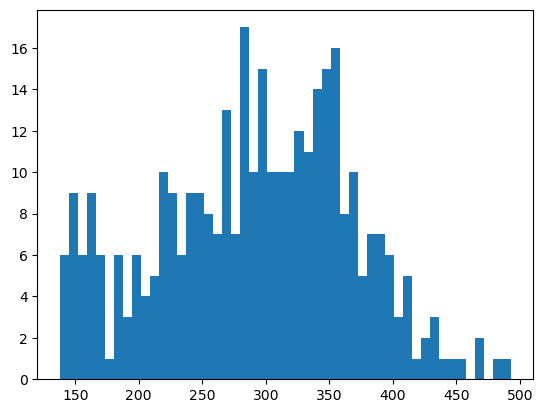

In [15]:
plt.hist(torch.count_nonzero(cloud0.pointcloudvoxel.points_in_voxel+1, dim=1).cpu().numpy(), bins=50)
plt.yscale('linear')

Backward ray tracing relies on doing a line integral along each ray. We do so by sampling a set of points along each ray and summing up the contributions at each of those points. Here we use a _hierarchical sampling_, which first spaces a set of points uniformly along the ray, and then does an importance sampling of additional points with notable density to "focus" on regions of interest. We do a stratified sampling on top of this, perturbing the uniformly spaced points to better approximate a continuous integral.

Our object of interest is a transparent atom cloud, meaning that we only integrate the density: the contribution of a ray to a given pixel intensity is given by:
\begin{equation}
C(\mathbf{r}) \propto \int \sigma(\mathbf{r}(t))dt
\end{equation}

For other contexts (such as [NeRF](https://www.matthewtancik.com/nerf)), these integrals include a view (ray direction) dependent color as well as a transmittance term (the probability of a light ray terminating as it moves through a given density).


The integration is done only within the spherical region of interest that we defined above. Generating images then is done as follows:

In [16]:
# Define an integrator
from gradoptics.integrator import HierarchicalSamplingIntegrator

# 32 uniformly spaced points, 32 additional points
integrator = HierarchicalSamplingIntegrator(32, 16)

# Loop over cameras
targets_backward = []
use_pinhole = False

nloops = 100

if use_pinhole:
    # pinhole camera
    for i_cam in tqdm(range(n_cameras)):
        # Generate rays for each camera (all pixels at once). i_cam*2 gives all sensor idxs, lenses are i_cam*2+1
        incident_rays = get_rays_pinhole(scene.objects[i_cam*2], scene.objects[i_cam*2+1])
        
        # Trace rays through the scene (includes the integration)
        intensities = optics.backward_ray_tracing(incident_rays, scene, 
                                                    scene.light_source, integrator, max_iterations=3)
        
        # Store the result for a given camera
        targets_backward.append(intensities.cpu().clone().reshape(scene.objects[i_cam*2].resolution))
        
        del intensities
else:
    for i_cam in range(n_cameras):
        sensor = scene.objects[i_cam*2]
        lens = scene.objects[i_cam*2+1]
        indicesx, indicesy = torch.arange(-sensor.resolution[0]/2, sensor.resolution[0]/2), torch.arange(-sensor.resolution[1]/2, sensor.resolution[1]/2)
        meshidx, meshidy = torch.meshgrid(indicesx, indicesy)
        meshidx = meshidx.reshape((sensor.resolution[0]*sensor.resolution[1]))
        meshidy = meshidy.reshape((sensor.resolution[0]*sensor.resolution[1]))
        
        sumintensities = torch.zeros((sensor.resolution[0], sensor.resolution[1]), dtype=torch.float64, device='cuda')
        # split sensors into nparts
        nparts = 100
        pixperpart = int(sensor.resolution[0]*sensor.resolution[1] / nparts)
        for _ in tqdm(range(nloops), desc='iter'):
            sensorintensities=[]
            for ipart in tqdm(range(nparts), desc='parts'):
                meshidx_part = meshidx[pixperpart*ipart:pixperpart*(ipart+1)]
                meshidy_part = meshidy[pixperpart*ipart:pixperpart*(ipart+1)]
                intensity = render_pixels(sensor, lens, scene, scene.light_source, 1, 2, meshidx_part, meshidy_part, integrator, device='cuda')
                sensorintensities.append(intensity)
            sumintensities += torch.cat(sensorintensities).reshape((sensor.resolution[0], sensor.resolution[1])) / nloops
        
        targets_backward.append(sumintensities.cpu().clone())
        del sumintensities

#intensities_backward = [np.sum(targets_backward[i].cpu().numpy()) for i in range(len(targets_backward))]
intensities_backward = [np.sum(targets_backward[i].numpy()) for i in range(len(targets_backward))]
print(intensities_backward)

iter:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Alesi\AppData\Local\Temp\ipykernel_58812\1111823045.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sensor_normal = (lens.transform.transform[:-1, -1]-torch.tensor(sensor.position)).to(device)
iter: 100%|██████████| 100/100 [1:11:49<00:00, 43.09s/it]

[6036893.697224475, 6022513.375621293]


In [17]:
#intensities_backward[0] / intensities_backward[2]

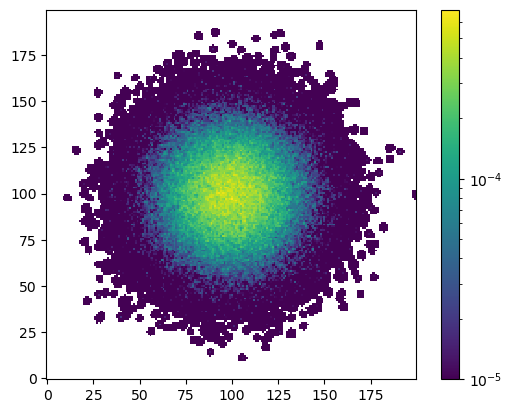

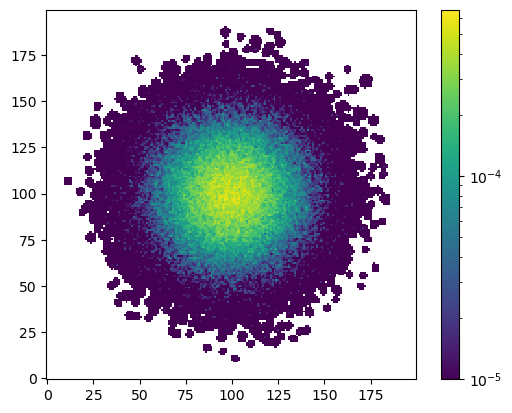

In [18]:
for i in range(len(targets_backward)):
    plt.imshow(targets_backward[i].T.cpu().clone() / intensities_backward[i], origin='lower', norm=matplotlib.colors.LogNorm(vmin=1e-5), interpolation='none')
    plt.colorbar()
    #plt.savefig(f'targets_backward{i}_cos_{mode}.png')
    plt.show()

## Adaptive sampling for Forward Ray Tracing

In [19]:
#Define utiity functions

def vec_costh(atensor : torch.Tensor):
    return atensor[:, 2].unsqueeze(1)

def vec_phi(atensor : torch.Tensor):
    return torch.arctan2(atensor[:, 1], atensor[:, 0]).unsqueeze(1)

In [20]:
# adaptive sampling
from gradoptics.ray_tracing import ray_tracing

ntotalrays=2e7
nrayspertrial=1e6
ntrials = int(ntotalrays/nrayspertrial)

directionslist = []
rawdatalist = []
for itrials in tqdm(range(ntrials)):
    raystrial = scene.light_source.sample_rays(int(nrayspertrial), device='cuda')
    _, _, mask = ray_tracing.trace_rays(raystrial, scene)
    directionslist.append(raystrial[mask].directions.cpu().numpy().astype(np.float32))
    rawdatalist.append(raystrial.directions.cpu().numpy().astype(np.float32))
directionsnp = np.vstack(directionslist).astype(np.float32)
rawdatanp = np.vstack(rawdatalist).astype(np.float32)
#rawdatanp = raystrial.directions.numpy()

100%|██████████| 20/20 [00:01<00:00, 11.59it/s]


In [21]:
costhetas  = vec_costh(raystrial[mask].directions.cpu()).numpy().astype(np.float32)
phis  = vec_phi(raystrial[mask].directions.cpu()).numpy().astype(np.float32)

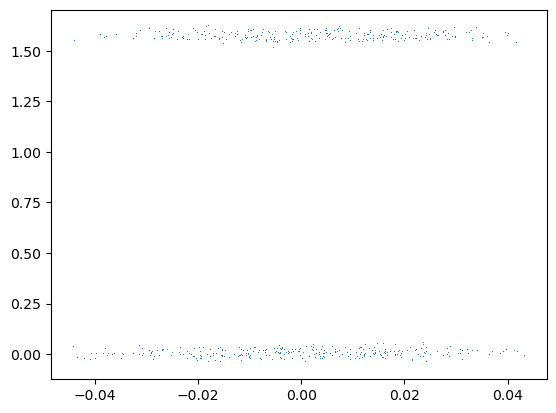

In [22]:
plt.plot(costhetas[:1000000], phis[:1000000], ',')
plt.show()

In [23]:
centroids, maxdist, counts, counts_all = kwindows(directionsnp, rawdatanp, directionsnp)
print(centroids)
print(counts)
print(counts_all)
print(maxdist)


[[ 9.9999994e-01  3.5314535e-04 -7.3119707e-05]
 [ 6.3003862e-04  9.9999976e-01  2.9611756e-04]]
[5307, 5282]
[25256, 23480]
[0.07095154523849488, 0.06828742995858193]


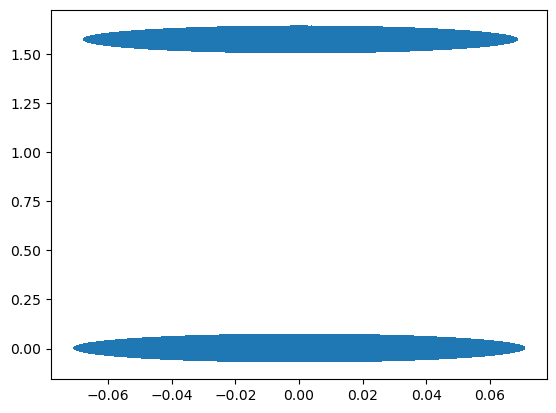

In [24]:
sampled, cts = weighted_sampler(2800000, centroids, maxdist, counts_all)
sampled_thetas = sampled[:, 2]
samepld_phis = np.arctan2(sampled[:, 1], sampled[:, 0])
plt.plot(sampled_thetas, samepld_phis, ',')
plt.show()

In [25]:
from gradoptics import Rays
from gradoptics.optics import normalize_batch_vector

def importance_sampledrays(nb_rays, device='cpu'):
    directionvectors,_ = weighted_sampler(nb_rays, centroids, maxdist, counts_all)
    origins = scene.light_source.distribution.sample(nb_rays, device=device).to(torch.float32)
    
    directions = normalize_batch_vector(torch.tensor(directionvectors).to(torch.float32))
    torch.cuda.empty_cache()
    return Rays(origins, directions, device=device)

## Forward imaging

In [26]:
@torch.no_grad()
def make_image(scene, device='cpu', nb_rays=int(1e8), batch_size=int(1e6), quantum_efficiency=True, max_iterations=2,
               add_poisson_noise=True, lookup_table=None, show_progress=True, destructive_readout=True):
    
    progress_bar = tqdm if show_progress else lambda x: x
    nb_rays_left_to_sample = nb_rays
    for _ in progress_bar(range(int(np.ceil(nb_rays / batch_size)))):
        #rays = scene.light_source.sample_rays(min(batch_size, nb_rays_left_to_sample), device=device)
        rays = importance_sampledrays(min(batch_size, nb_rays_left_to_sample), device=device)
        optics.forward_ray_tracing(rays, scene, max_iterations=max_iterations)
        nb_rays_left_to_sample -= batch_size

        #del rays
        #torch.cuda.empty_cache()

    #return scene.objects[0].readout(add_poisson_noise=add_poisson_noise, destructive_readout=destructive_readout)
    pass

In [40]:
nphotonsfromcloud = 1e9
nbrays_forward=5e9 # restricted


nphotons = np.sum(counts_all)*(nphotonsfromcloud/ntotalrays) # nphotons in acceptance per 1e9 generated
scalefactor = nbrays_forward/nphotons
print(scalefactor)

#make_image(scene, nb_rays=int(1e10), batch_size=int(1e7), device='cuda')
make_image(scene, nb_rays=int(nbrays_forward), batch_size=int(2e7), device='cuda') # reweighted

2051.871306631648


100%|██████████| 250/250 [14:35<00:00,  3.50s/it]


### Resulting images

In [41]:
%matplotlib inline
usenoise = False
allsensors = get_sensors(scene)
targets_forward = [allsensors[i].readout(add_poisson_noise = usenoise, destructive_readout = True).cpu().clone().reshape(allsensors[i].resolution).numpy() for i in range(len(allsensors))]
# need to flip ...
targets_forward = [np.flip(tgt) for tgt in targets_forward]
intensities_forward = [np.sum(targets_forward[i]) for i in range(len(targets_forward))]
print(intensities_forward)

[390471780.0, 391904480.0]


In [29]:
#with open(f'intensities_forward_reweights_{mode}.pkl', 'wb') as file:
#    pickle.dump(targets_forward, file)

In [30]:
#with open(f'intensities_forward_reweights_{mode}.pkl', 'rb') as file:
#    targets_forward = pickle.load(file)


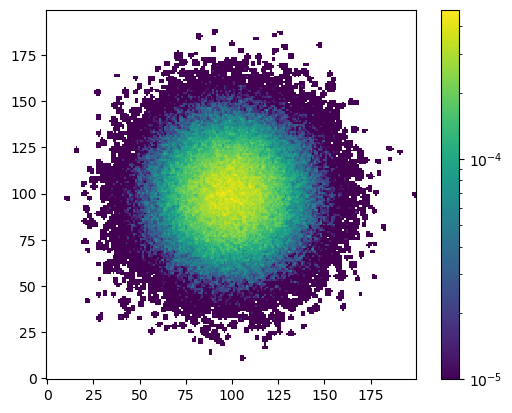

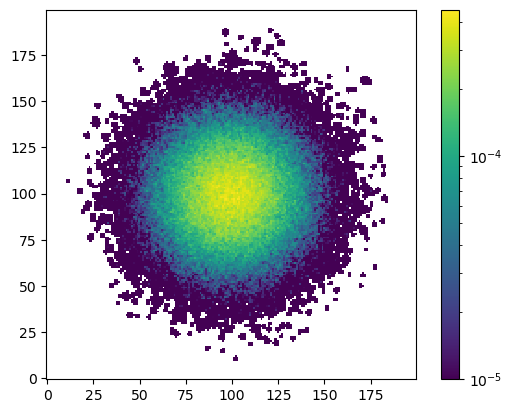

In [42]:
usenoise = False
for i in range(len(targets_forward)):
    plt.imshow(targets_forward[i]/intensities_forward[i], origin='lower', norm=matplotlib.colors.LogNorm(vmin=1e-5), interpolation='none')
    plt.colorbar()
    #if usenoise:
    #    plt.savefig(f'targets_forward{i}_noise.png')
    #else:
    #    plt.savefig(f'targets_forward{i}_{mode}.png')
    plt.show()

## Poisson sample 

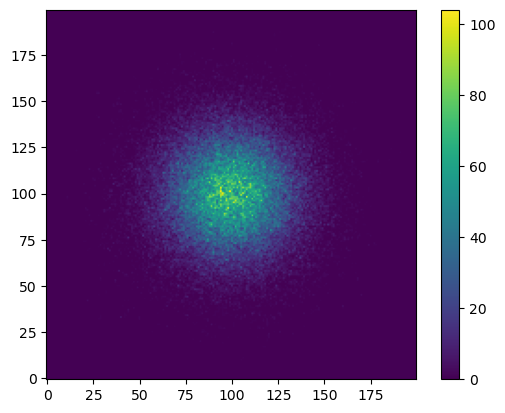

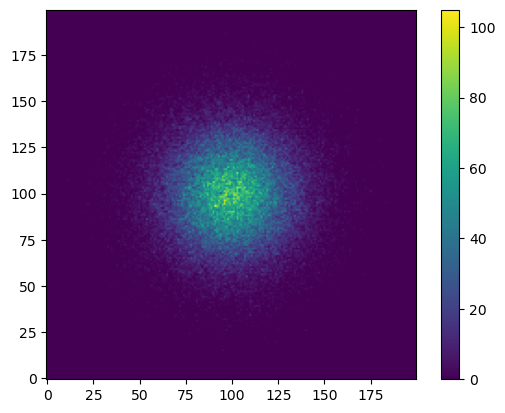

In [32]:
useforwardsample = True

#scalefactor = 1.0e9/(330000.0*10.0)
targets_forward_sample_np = targets_forward_real = [None]*ncams
noisemean = 0.0
for i in range(len(targets_forward)):
    if useforwardsample:
        targets_forward_real[i] = targets_forward[i].T / scalefactor + noisemean
    else:
        targets_forward_real[i] = targets_backward[i] * intensities_forward[i] / intensities_backward[i] / scalefactor + noisemean
    targets_forward_sample_np[i] = np.random.poisson(targets_forward_real[i], None).astype(np.float64)
    plt.imshow(targets_forward_sample_np[i].T, origin='lower')
    plt.colorbar()
    plt.show()

targets_forward_sample = []
for a in targets_forward_sample_np:
    targets_forward_sample.append(torch.tensor(a))

In [33]:
intensities_forward = [np.sum(targets_forward_sample_np[i]) for i in range(len(targets_forward_sample_np))]
print(intensities_forward)

[190755.0, 191799.0]


## compare forward and backward ray tracing

C:\Users\Alesi\AppData\Local\Temp\ipykernel_58812\1322542867.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(targets_backward[camtocomp].T / targets_forward[camtocomp] * vmax, vmin=0.0, vmax=2.0, cmap='seismic', origin='lower')
C:\Users\Alesi\AppData\Local\Temp\ipykernel_58812\1322542867.py:5: RuntimeWarning: invalid value encountered in divide
  plt.imshow(targets_backward[camtocomp].T / targets_forward[camtocomp] * vmax, vmin=0.0, vmax=2.0, cmap='seismic', origin='lower')


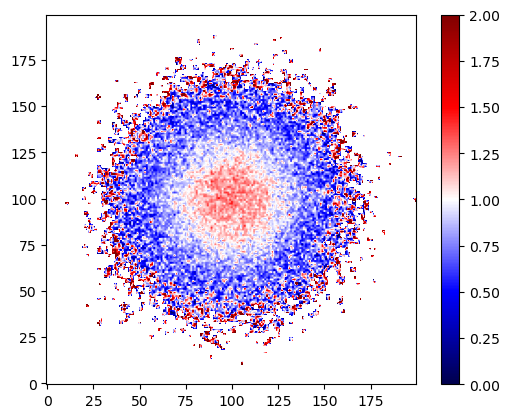

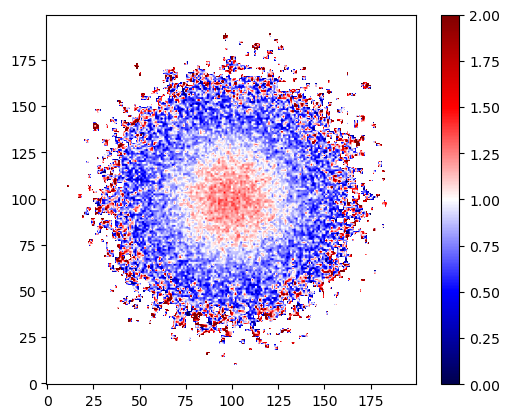

In [43]:
for i in range(len(targets_forward)):
    camtocomp=i
    vmax = intensities_forward[i] / intensities_backward[i]
    #plt.imshow(np.flip(targets_forward[camtocomp], axis=1) / targets_backward[camtocomp].T, vmax=vmax, vmin=0, cmap='seismic')
    plt.imshow(targets_backward[camtocomp].T / targets_forward[camtocomp] * vmax, vmin=0.0, vmax=2.0, cmap='seismic', origin='lower')
    plt.colorbar()
    #plt.savefig(f'ratio_fb_cam{i}_reweight_cos_{mode}.png')
    plt.show()

C:\Users\Alesi\AppData\Local\Temp\ipykernel_58812\2817947457.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.hist(targets_backward[camtocomp].T.flatten() / targets_forward[camtocomp].flatten() * vmax, range=(0.0, 3.0), bins=100)
C:\Users\Alesi\AppData\Local\Temp\ipykernel_58812\2817947457.py:5: RuntimeWarning: invalid value encountered in divide
  plt.hist(targets_backward[camtocomp].T.flatten() / targets_forward[camtocomp].flatten() * vmax, range=(0.0, 3.0), bins=100)


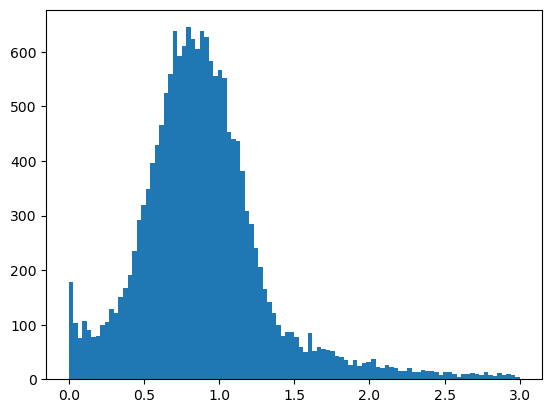

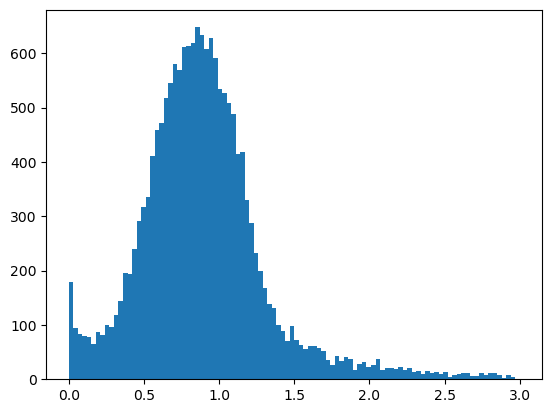

In [44]:
for i in range(len(targets_forward)):
    camtocomp=i
    vmax = intensities_forward[i] / intensities_backward[i]
    #plt.imshow(np.flip(targets_forward[camtocomp], axis=1) / targets_backward[camtocomp].T, vmax=vmax, vmin=0, cmap='seismic')
    plt.hist(targets_backward[camtocomp].T.flatten() / targets_forward[camtocomp].flatten() * vmax, range=(0.0, 3.0), bins=100)
    plt.show()

In [36]:
def compute_profile(x, y, histrange, nbin=(100,100)):
    
    # use of the 2d hist by numpy to avoid plotting
    _, xe, _ = np.histogram2d(x,y,nbin, histrange)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array      = []
    x_slice_mean = []
    x_slice_rms  = []
    for i in range(xe.size-1):
        yvals = y[ (x>=xe[i]) & (x<xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            x_slice_rms.append( yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

C:\Users\Alesi\AppData\Local\Temp\ipykernel_58812\128813733.py:9: RuntimeWarning: divide by zero encountered in divide
  yval = targets_backward[camtocomp].T.flatten() / targets_forward[camtocomp].flatten() * vmax -1.0
C:\Users\Alesi\AppData\Local\Temp\ipykernel_58812\128813733.py:9: RuntimeWarning: invalid value encountered in divide
  yval = targets_backward[camtocomp].T.flatten() / targets_forward[camtocomp].flatten() * vmax -1.0


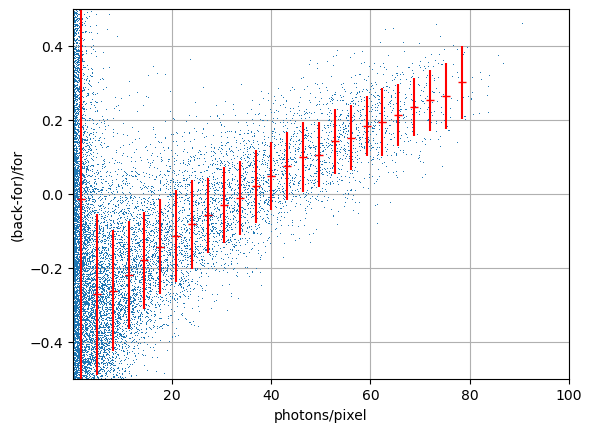

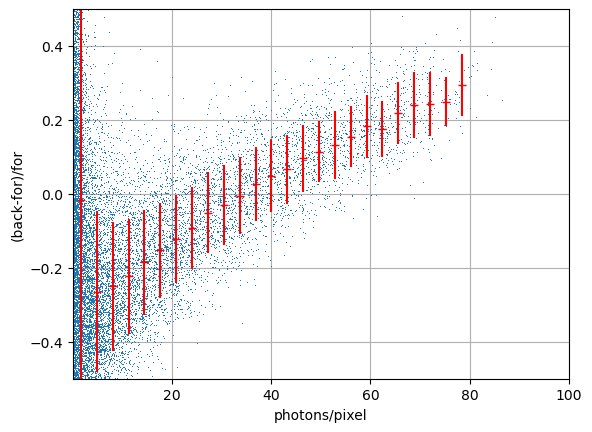

In [45]:
xp= [i for i in range(100)]
vsig = np.sqrt(xp)
histrange = [[0.1, 80], [-1.5, 1.5]]
for i in range(len(targets_forward)):
    camtocomp=i
    vmax = intensities_forward[i] / intensities_backward[i]
    #plt.imshow(np.flip(targets_forward[camtocomp], axis=1) / targets_backward[camtocomp].T, vmax=vmax, vmin=0, cmap='seismic')
    xval = targets_forward[camtocomp].flatten() / scalefactor
    yval = targets_backward[camtocomp].T.flatten() / targets_forward[camtocomp].flatten() * vmax -1.0
    yval = yval.numpy()
    xarr, xslice_mean, xslice_rms = compute_profile(xval, yval, histrange, (25, 25))
    plt.plot(xval, yval, ',')
    #plt.hist2d(xval, yval, bins=(np.arange(0.1, 100, 1.0), np.arange(-1.5, 1.5, 0.1)), cmap='GnBu')
    plt.errorbar(xarr, xslice_mean, xslice_rms,fmt='_', ecolor='r', color='r')
    #plt.plot(xp, vsig/xp)
    #plt.plot(xp, -vsig/xp)
    plt.xlabel('photons/pixel')
    plt.ylabel('(back-for)/for')
    plt.xlim(0.1,100.0)
    plt.ylim(-0.5, 0.5)
    #plt.xscale('log')
    plt.grid()
    plt.show()

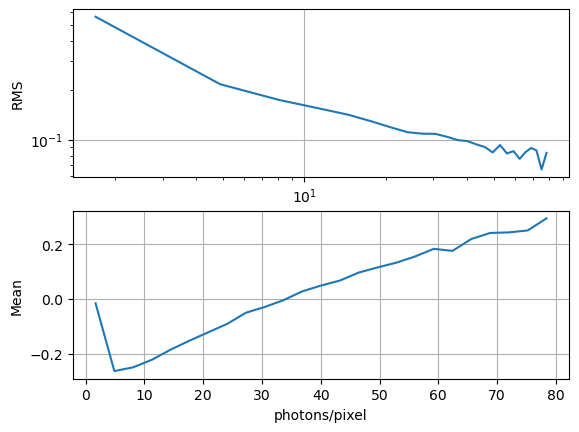

In [46]:
fig, ax = plt.subplots(2, 1)
plt.sca(ax[0])
plt.plot(xarr, xslice_rms)
#plt.plot(xarr, np.sqrt(xslice_rms)/4)
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('RMS')
plt.sca(ax[1])
plt.plot(xarr, xslice_mean)
plt.xlabel('photons/pixel')
plt.ylabel('Mean')
plt.grid()
plt.show()

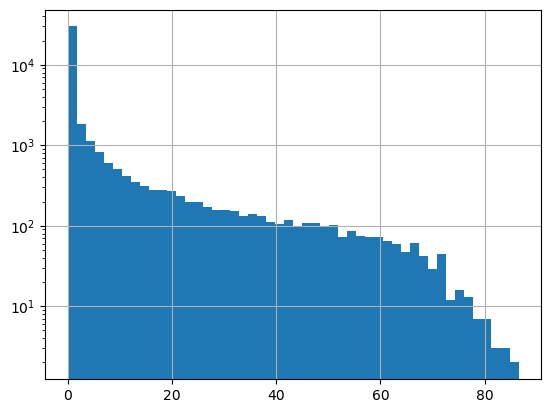

In [47]:
_ = plt.hist(xval, 50)
plt.yscale('log')
plt.grid()
plt.show()